# A custom xgboost classifier pipeline which does early stopping within cross validation, feature selection, and probability calibration

In [2]:
# Import modules

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import markers
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, auc, classification_report, f1_score, log_loss, precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.feature_selection import mutual_info_classif, SelectFromModel, SelectKBest
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import LabelBinarizer
from xgboost.sklearn import XGBClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from random import uniform
from bayes_opt import BayesianOptimization

In [3]:
# Set plot style
plt.style.use('dark_background')

In [4]:
# Set pandas preferences:
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000

# Load some easy sample data for testing

In [5]:
from sklearn import datasets

In [6]:
cancer = datasets.load_breast_cancer()

In [7]:
X = cancer.data

In [8]:
y = cancer.target

In [9]:
# There's not a lot of data here...
from sklearn.datasets import make_classification

In [10]:
data, target = make_classification(n_samples=10000,
                                   n_features=50,
                                   n_informative=30,
                                   n_redundant=10)

In [11]:
# This is a balanced dataset already.

In [12]:
# Split up the data as needed.
train_X, calibrate_X, train_y, calibrate_y = train_test_split(data, target, test_size=0.1)

In [13]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2)

# Some useful functions

In [14]:
def make_roc_curves_array(true_vals, scores_vals, figsize=(10,10)):
    """Function for making nice-ish looking roc curves."""
    fpr, tpr, threshold = roc_curve(y_true=true_vals, y_score=scores_vals)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr, threshold, roc_auc

In [15]:
def make_roc_curves_df(df, true_col, scores_col, figsize=(10,10)):
    """Function for making nice-ish looking roc curves."""
    fpr, tpr, threshold = roc_curve(y_true=df[true_col].values, y_score=df[scores_col].values)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr, threshold, roc_auc

In [16]:
def calibration_func_array(true_vals, probability_vals_list, legend_labels, title, n_bins=20, figsize=(10,10)):
    """Function for making reliability plots"""
    y_vals = []
    x_vals = []
    for vals in probability_vals_list:
        y_array, x_array = calibration_curve(true_vals, vals, n_bins=n_bins)
        y_vals.append(y_array)
        x_vals.append(x_array)
    
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(0, len(legend_labels)):
        plt.plot(x_vals[i], y_vals[i], linewidth=1, label=legend_labels[i], marker=markers.MarkerStyle.filled_markers[i])
    
    # Reference line, legends, and axis labels
    line = mlines.line2D([0, 1], [0, 1], color='white')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    fig.suptitle(title)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability in each bin')
    plt.legend()
    plt.show()

# Custom xgboost classifier class object

In [17]:
class EarlyStoppingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier, evaluation_metric, num_rounds, feature_selector=None, validation_size=None):
        self.classifier = classifier
        self.evaluation_metric = evaluation_metric
        self.num_rounds = num_rounds
        self.feature_selector = feature_selector
        self.validation_size = validation_size
        self.classes_ = None
        self.classifier_ = None
        self.feature_selector_ = None
        
    def fit(self, X, y):
        """Function for fitting the base estimator.  Implements feature selection and also auto generates a validation set for early stopping.
        Also supports probability calibration."""
        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        
        # Do feature selection if desired
        if self.feature_selector:
            X_use = self.feature_select(X, y)
        else:
            X_use = X
        
        # Make the validation set:
        X_train, X_valid, y_train, y_valid = self.make_validation_set(X_use, y)

        # Fit the base estimator
        self.classifier_ = clone(self.classifier)
        self.classifier = self.classifier_.fit(X_train,
                                               y_train,
                                               eval_metric=self.evaluation_metric,
                                               eval_set=[[X_valid, y_valid]],
                                               early_stopping_rounds=self.num_rounds)
        
        return self
    
    def predict(self, X):
        """Makes predictions on input data from trained classifier.  
        If feature selection is used, it is applied automatically to the input data."""
        # The predict function changes in XGBoost when early stopping is performed.
        if self.feature_selector:
            X_select = self.feature_selector.transform(X)
        else:
            X_select = X
            
        # This method should only be called once the model is fit anyway, and since we are always using early stopping, 
        # we can set ntree_limit by default.
        return self.classifier.predict(X_select, ntree_limit=self.classifier.best_ntree_limit)
    
    def predict_proba(self, X):
        """Makes probability predictions on input data from trained classifier.  If feature selection is used,
        it is applied automatically to the input data.  Since this method should only be called after the 
        classifier is fit, and since we are always using early stopping, the best_ntree_limit should be defined by default."""
        if self.feature_selector:
            X_select = self.feature_selector.transform(X)
        else:
            X_select = X
        
        return self.classifier.predict_proba(X_select, ntree_limit=self.classifier.best_ntree_limit)

    def feature_select(self, X, y):
        """Implements feature selection if so desired."""
        # TODO: Get tree based feature selection working.
        self.feature_selector_ = clone(self.feature_selector)
        self.feature_selector = self.feature_selector_.fit(X, y)
        
        return self.feature_selector.transform(X)
        
    def make_validation_set(self, X, y):
        """Makes the validation set."""
        if self.validation_size:
            val_size = self.validation_size
        else:
            val_size = 0.1
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=val_size)
        return X_train, X_valid, y_train, y_valid

In [18]:
cv = 5

In [19]:
params_feature_select_xgb = EarlyStoppingClassifier(classifier=XGBClassifier(objective='binary:logistic', booster='gbtree', silent=True),
                                                    feature_selector=SelectKBest(score_func=mutual_info_classif),
                                                    evaluation_metric='logloss',
                                                    num_rounds=5)

In [20]:
param_grid = {'feature_selector__k': sp_randint(20, 45),
              'classifier__max_depth': sp_randint(3, 15),
              'classifier__min_child_weight': sp_randint(1, 5),
              'classifier__learning_rate': np.random.uniform(low=0.01, high=0.2, size=(100,)),
              'classifier__n_estimators': [1000],
              'classifier__colsample_bytree': np.random.uniform(low=0.7, high=1, size=(100,)),
              'classifier__subsample': np.random.uniform(low=0.7, high=1, size=(100,)),
              'classifier__seed': [0]}

In [21]:
# Let's try something a bit different.  First a random gridsearch.
model_gen_random = RandomizedSearchCV(estimator=params_feature_select_xgb, 
                                      param_distributions=param_grid, 
                                      cv=cv, 
                                      scoring='recall', 
                                      verbose=10, 
                                      iid=True, 
                                      refit=False, 
                                      n_iter=15)

In [22]:
model_gen_random.fit(train_X, train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] classifier__colsample_bytree=0.921820499464, classifier__subsample=0.757975437215, classifier__learning_rate=0.14713566421, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=37, classifier__min_child_weight=3, classifier__max_depth=6 
[0]	validation_0-logloss:0.643343
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.597316
[2]	validation_0-logloss:0.562384
[3]	validation_0-logloss:0.531376
[4]	validation_0-logloss:0.504526
[5]	validation_0-logloss:0.4798
[6]	validation_0-logloss:0.460827
[7]	validation_0-logloss:0.443407
[8]	validation_0-logloss:0.428793
[9]	validation_0-logloss:0.416624
[10]	validation_0-logloss:0.401174
[11]	validation_0-logloss:0.391912
[12]	validation_0-logloss:0.380464
[13]	validation_0-logloss:0.369141
[14]	validation_0-logloss:0.361606
[15]	validation_0-logloss:0.350785
[16]	validation_0-logloss:0.344298
[17]	validation_0-logloss:0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[0]	validation_0-logloss:0.638296
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.594718
[2]	validation_0-logloss:0.555409
[3]	validation_0-logloss:0.528818
[4]	validation_0-logloss:0.503172
[5]	validation_0-logloss:0.477898
[6]	validation_0-logloss:0.459124
[7]	validation_0-logloss:0.442586
[8]	validation_0-logloss:0.426865
[9]	validation_0-logloss:0.412082
[10]	validation_0-logloss:0.396465
[11]	validation_0-logloss:0.386951
[12]	validation_0-logloss:0.371444
[13]	validation_0-logloss:0.360531
[14]	validation_0-logloss:0.349741
[15]	validation_0-logloss:0.341637
[16]	validation_0-logloss:0.332534
[17]	validation_0-logloss:0.325347
[18]	validation_0-logloss:0.319948
[19]	validation_0-logloss:0.314527
[20]	validation_0-logloss:0.308846
[21]	validation_0-logloss:0.304488
[22]	validation_0-logloss:0.297989
[23]	validation_0-logloss:0.294425
[24]	validation_0-logloss:0.290169
[25]	validation_0-logloss:0.285318
[26]	validation_0-logloss:0.28452

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s


[0]	validation_0-logloss:0.643752
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.604768
[2]	validation_0-logloss:0.573765
[3]	validation_0-logloss:0.548756
[4]	validation_0-logloss:0.524937
[5]	validation_0-logloss:0.505899
[6]	validation_0-logloss:0.487295
[7]	validation_0-logloss:0.474599
[8]	validation_0-logloss:0.457882
[9]	validation_0-logloss:0.444038
[10]	validation_0-logloss:0.43321
[11]	validation_0-logloss:0.422343
[12]	validation_0-logloss:0.410695
[13]	validation_0-logloss:0.399116
[14]	validation_0-logloss:0.391766
[15]	validation_0-logloss:0.382246
[16]	validation_0-logloss:0.375467
[17]	validation_0-logloss:0.3686
[18]	validation_0-logloss:0.363867
[19]	validation_0-logloss:0.357522
[20]	validation_0-logloss:0.351034
[21]	validation_0-logloss:0.345043
[22]	validation_0-logloss:0.341857
[23]	validation_0-logloss:0.335642
[24]	validation_0-logloss:0.33124
[25]	validation_0-logloss:0.327476
[26]	validation_0-logloss:0.323948
[2

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.3s remaining:    0.0s


[0]	validation_0-logloss:0.641442
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.596014
[2]	validation_0-logloss:0.563832
[3]	validation_0-logloss:0.536051
[4]	validation_0-logloss:0.508175
[5]	validation_0-logloss:0.485969
[6]	validation_0-logloss:0.46886
[7]	validation_0-logloss:0.453342
[8]	validation_0-logloss:0.442659
[9]	validation_0-logloss:0.429372
[10]	validation_0-logloss:0.418435
[11]	validation_0-logloss:0.402891
[12]	validation_0-logloss:0.392464
[13]	validation_0-logloss:0.379203
[14]	validation_0-logloss:0.369977
[15]	validation_0-logloss:0.365335
[16]	validation_0-logloss:0.360282
[17]	validation_0-logloss:0.356346
[18]	validation_0-logloss:0.350049
[19]	validation_0-logloss:0.341918
[20]	validation_0-logloss:0.335317
[21]	validation_0-logloss:0.330749
[22]	validation_0-logloss:0.328355
[23]	validation_0-logloss:0.325483
[24]	validation_0-logloss:0.322303
[25]	validation_0-logloss:0.317177
[26]	validation_0-logloss:0.312912

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.3s remaining:    0.0s


[0]	validation_0-logloss:0.642282
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.602297
[2]	validation_0-logloss:0.566166
[3]	validation_0-logloss:0.537831
[4]	validation_0-logloss:0.512205
[5]	validation_0-logloss:0.49393
[6]	validation_0-logloss:0.470858
[7]	validation_0-logloss:0.454738
[8]	validation_0-logloss:0.436784
[9]	validation_0-logloss:0.423727
[10]	validation_0-logloss:0.411708
[11]	validation_0-logloss:0.398676
[12]	validation_0-logloss:0.388463
[13]	validation_0-logloss:0.37795
[14]	validation_0-logloss:0.369404
[15]	validation_0-logloss:0.360623
[16]	validation_0-logloss:0.350724
[17]	validation_0-logloss:0.343058
[18]	validation_0-logloss:0.336948
[19]	validation_0-logloss:0.331044
[20]	validation_0-logloss:0.327571
[21]	validation_0-logloss:0.325141
[22]	validation_0-logloss:0.319136
[23]	validation_0-logloss:0.316587
[24]	validation_0-logloss:0.314354
[25]	validation_0-logloss:0.309865
[26]	validation_0-logloss:0.307282


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.3s remaining:    0.0s


[0]	validation_0-logloss:0.688025
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.683926
[2]	validation_0-logloss:0.679287
[3]	validation_0-logloss:0.674748
[4]	validation_0-logloss:0.670274
[5]	validation_0-logloss:0.665589
[6]	validation_0-logloss:0.661525
[7]	validation_0-logloss:0.657061
[8]	validation_0-logloss:0.652854
[9]	validation_0-logloss:0.648919
[10]	validation_0-logloss:0.64509
[11]	validation_0-logloss:0.640792
[12]	validation_0-logloss:0.637265
[13]	validation_0-logloss:0.633801
[14]	validation_0-logloss:0.630064
[15]	validation_0-logloss:0.626285
[16]	validation_0-logloss:0.62264
[17]	validation_0-logloss:0.61898
[18]	validation_0-logloss:0.615614
[19]	validation_0-logloss:0.612391
[20]	validation_0-logloss:0.609305
[21]	validation_0-logloss:0.605953
[22]	validation_0-logloss:0.602598
[23]	validation_0-logloss:0.598838
[24]	validation_0-logloss:0.595227
[25]	validation_0-logloss:0.592006
[26]	validation_0-logloss:0.589174
[

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   41.4s remaining:    0.0s


[0]	validation_0-logloss:0.689039
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684949
[2]	validation_0-logloss:0.680301
[3]	validation_0-logloss:0.67608
[4]	validation_0-logloss:0.672033
[5]	validation_0-logloss:0.667754
[6]	validation_0-logloss:0.663825
[7]	validation_0-logloss:0.659326
[8]	validation_0-logloss:0.655214
[9]	validation_0-logloss:0.651433
[10]	validation_0-logloss:0.647745
[11]	validation_0-logloss:0.64367
[12]	validation_0-logloss:0.639873
[13]	validation_0-logloss:0.636154
[14]	validation_0-logloss:0.632843
[15]	validation_0-logloss:0.629184
[16]	validation_0-logloss:0.625883
[17]	validation_0-logloss:0.622067
[18]	validation_0-logloss:0.618773
[19]	validation_0-logloss:0.615465
[20]	validation_0-logloss:0.612037
[21]	validation_0-logloss:0.608806
[22]	validation_0-logloss:0.60557
[23]	validation_0-logloss:0.602667
[24]	validation_0-logloss:0.599293
[25]	validation_0-logloss:0.596311
[26]	validation_0-logloss:0.593212
[

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   58.0s remaining:    0.0s


[0]	validation_0-logloss:0.688613
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684095
[2]	validation_0-logloss:0.680093
[3]	validation_0-logloss:0.676051
[4]	validation_0-logloss:0.671657
[5]	validation_0-logloss:0.667609
[6]	validation_0-logloss:0.66351
[7]	validation_0-logloss:0.659265
[8]	validation_0-logloss:0.65506
[9]	validation_0-logloss:0.651232
[10]	validation_0-logloss:0.647159
[11]	validation_0-logloss:0.643611
[12]	validation_0-logloss:0.639758
[13]	validation_0-logloss:0.636637
[14]	validation_0-logloss:0.633284
[15]	validation_0-logloss:0.62986
[16]	validation_0-logloss:0.626639
[17]	validation_0-logloss:0.623443
[18]	validation_0-logloss:0.620441
[19]	validation_0-logloss:0.617077
[20]	validation_0-logloss:0.61396
[21]	validation_0-logloss:0.610808
[22]	validation_0-logloss:0.607362
[23]	validation_0-logloss:0.603871
[24]	validation_0-logloss:0.600984
[25]	validation_0-logloss:0.598106
[26]	validation_0-logloss:0.595088
[2

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[0]	validation_0-logloss:0.688663
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684605
[2]	validation_0-logloss:0.680313
[3]	validation_0-logloss:0.676354
[4]	validation_0-logloss:0.672531
[5]	validation_0-logloss:0.668351
[6]	validation_0-logloss:0.664439
[7]	validation_0-logloss:0.660507
[8]	validation_0-logloss:0.656611
[9]	validation_0-logloss:0.652645
[10]	validation_0-logloss:0.649175
[11]	validation_0-logloss:0.645094
[12]	validation_0-logloss:0.641847
[13]	validation_0-logloss:0.638103
[14]	validation_0-logloss:0.63453
[15]	validation_0-logloss:0.630599
[16]	validation_0-logloss:0.627443
[17]	validation_0-logloss:0.624418
[18]	validation_0-logloss:0.621294
[19]	validation_0-logloss:0.617981
[20]	validation_0-logloss:0.61458
[21]	validation_0-logloss:0.611512
[22]	validation_0-logloss:0.608422
[23]	validation_0-logloss:0.605427
[24]	validation_0-logloss:0.602496
[25]	validation_0-logloss:0.599522
[26]	validation_0-logloss:0.596389


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[0]	validation_0-logloss:0.688882
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684017
[2]	validation_0-logloss:0.679667
[3]	validation_0-logloss:0.675627
[4]	validation_0-logloss:0.671338
[5]	validation_0-logloss:0.666615
[6]	validation_0-logloss:0.662382
[7]	validation_0-logloss:0.658553
[8]	validation_0-logloss:0.654151
[9]	validation_0-logloss:0.650187
[10]	validation_0-logloss:0.646177
[11]	validation_0-logloss:0.642329
[12]	validation_0-logloss:0.638919
[13]	validation_0-logloss:0.634866
[14]	validation_0-logloss:0.631279
[15]	validation_0-logloss:0.62755
[16]	validation_0-logloss:0.624197
[17]	validation_0-logloss:0.62039
[18]	validation_0-logloss:0.617111
[19]	validation_0-logloss:0.614095
[20]	validation_0-logloss:0.610502
[21]	validation_0-logloss:0.607328
[22]	validation_0-logloss:0.60446
[23]	validation_0-logloss:0.600928
[24]	validation_0-logloss:0.597799
[25]	validation_0-logloss:0.595138
[26]	validation_0-logloss:0.591503
[

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  8.4min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective=...c=<function mutual_info_classif at 0x7f69860a85f0>),
            num_rounds=5, validation_size=None),
          fit_params=None, iid=True, n_iter=15, n_jobs=1,
          param_distributions={'feature_selector__k': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f698505ce50>, 'classifier__colsample_bytree': array([ 0.81856,  0.86855, ...,  0.70575,  0.84839]), 'classifier__subsample': array([ 0.96468,  0.86815, ...,  0.72843,  0.74757]), 'classifier__min_ch...0], 'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6984ddc110>},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,

In [23]:
model_gen_random.best_score_

0.93982370575775154

In [24]:
model_gen_random.best_params_

{'classifier__colsample_bytree': 0.8597849920460765,
 'classifier__learning_rate': 0.102813829364523,
 'classifier__max_depth': 7,
 'classifier__min_child_weight': 4,
 'classifier__n_estimators': 1000,
 'classifier__seed': 0,
 'classifier__subsample': 0.81875515354055473,
 'feature_selector__k': 44}

In [25]:
best_params_random = model_gen_random.best_params_

In [26]:
final_model_ran = EarlyStoppingClassifier(classifier=XGBClassifier(objective='binary:logistic', booster='gbtree', silent=True),
                                          feature_selector=SelectKBest(score_func=mutual_info_classif),
                                          evaluation_metric='logloss',
                                          num_rounds=5)

In [27]:
final_model_ran.set_params(**best_params_random)

EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8597849920460765, gamma=0,
       learning_rate=0.102813829364523, max_delta_step=0, max_depth=7,
       min_child_weight=4, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.81875515354055473),
            evaluation_metric='logloss',
            feature_selector=SelectKBest(k=44, score_func=<function mutual_info_classif at 0x7f69860a85f0>),
            num_rounds=5, validation_size=None)

In [28]:
final_model_ran.fit(train_X, train_y)

[0]	validation_0-logloss:0.651848
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.615474
[2]	validation_0-logloss:0.584588
[3]	validation_0-logloss:0.559632
[4]	validation_0-logloss:0.539549
[5]	validation_0-logloss:0.51945
[6]	validation_0-logloss:0.49993
[7]	validation_0-logloss:0.482863
[8]	validation_0-logloss:0.464468
[9]	validation_0-logloss:0.451323
[10]	validation_0-logloss:0.437621
[11]	validation_0-logloss:0.425929
[12]	validation_0-logloss:0.412737
[13]	validation_0-logloss:0.401359
[14]	validation_0-logloss:0.390277
[15]	validation_0-logloss:0.381599
[16]	validation_0-logloss:0.373058
[17]	validation_0-logloss:0.363608
[18]	validation_0-logloss:0.356551
[19]	validation_0-logloss:0.348622
[20]	validation_0-logloss:0.341495
[21]	validation_0-logloss:0.335969
[22]	validation_0-logloss:0.330502
[23]	validation_0-logloss:0.325313
[24]	validation_0-logloss:0.320019
[25]	validation_0-logloss:0.316901
[26]	validation_0-logloss:0.31169
[

EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8597849920460765, gamma=0,
       learning_rate=0.102813829364523, max_delta_step=0, max_depth=7,
       min_child_weight=4, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.81875515354055473),
            evaluation_metric='logloss',
            feature_selector=SelectKBest(k=44, score_func=<function mutual_info_classif at 0x7f69860a85f0>),
            num_rounds=5, validation_size=None)

In [29]:
final_model_ran.classifier.best_ntree_limit

127

In [30]:
ran_preds = final_model_ran.predict(test_X)

In [31]:
ran_preds_proba = final_model_ran.predict_proba(test_X)

In [32]:
accuracy_score(y_true=test_y, y_pred=ran_preds)

0.93833333333333335

In [36]:
# final_model_ran.classifier.predict(test_X)

In [37]:
recall_score(y_true=test_y, y_pred=ran_preds)

0.93259668508287297

In [38]:
precision_score(y_true=test_y, y_pred=ran_preds)

0.94407158836689042

In [39]:
# Shockingly good.

In [40]:
# Let's do a baseline...

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
lg_model = LogisticRegression(penalty='l1')

In [43]:
lg_model.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
lg_preds = lg_model.predict(test_X)
lg_preds_proba = lg_model.predict_proba(test_X)

In [63]:
accuracy_score(y_true=test_y, y_pred=lg_preds)

0.81722222222222218

In [64]:
recall_score(y_true=test_y, y_pred=lg_preds)

0.81436464088397786

In [65]:
precision_score(y_true=test_y, y_pred=lg_preds)

0.82071269487750553

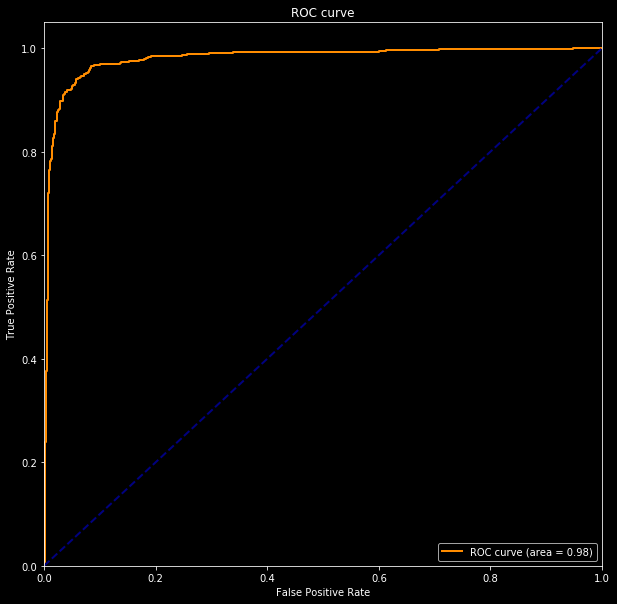

In [59]:
# hmm, nice.  
tpr, fpr, threshold, roc_auc_ = make_roc_curves_array(true_vals=test_y, scores_vals=ran_preds_proba[:,1])

In [58]:
ran_preds_proba[:,1]

array([ 0.00504231,  0.03139452,  0.94061673, ...,  0.02763894,
        0.98489481,  0.985753  ], dtype=float32)

In [52]:
ran_preds

array([0, 0, 1, ..., 0, 1, 1])

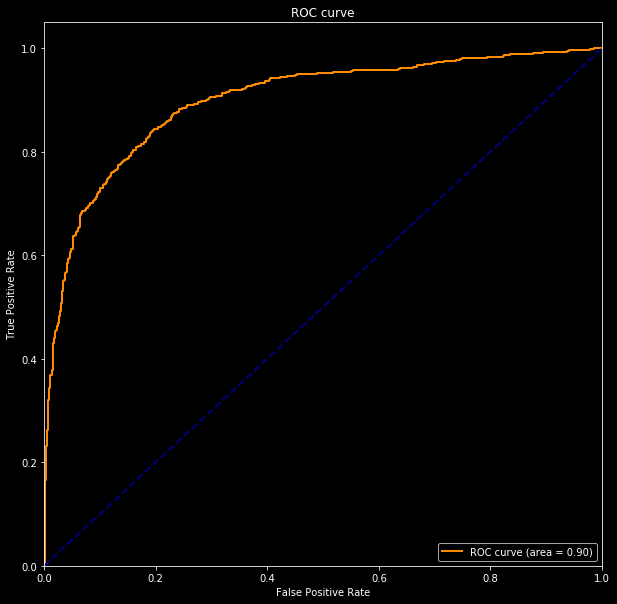

In [66]:
tpr, fpr, threshold, roc_auc_ = make_roc_curves_array(true_vals=test_y, scores_vals=lg_preds_proba[:,1])

In [61]:
lg_preds_proba

array([0, 0, 1, ..., 0, 1, 1])

In [69]:
df_test = pd.DataFrame(test_X)

In [71]:
df_test['y_true'] = test_y

In [72]:
df_test['xgb_proba_0'] = ran_preds_proba[:,0]

In [73]:
df_test['xgb_proba_1'] = ran_preds_proba[:,1]

In [74]:
df_test['lg_proba_0'] = lg_preds_proba[:,0]

In [75]:
df_test['lg_proba_1'] = lg_preds_proba[:,1]

In [76]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,y_true,xgb_proba_0,xgb_proba_1,lg_proba_0,lg_proba_1
0,0.926468,-5.163436,5.032171,-4.284233,1.586616,0.961695,-0.076148,-7.267543,-0.515355,2.583838,-3.051218,9.458839,3.615775,-1.262092,-5.959945,0.241937,6.873686,-4.652448,3.489553,-1.334561,3.134550,0.205682,19.868138,-1.215610,0.119084,-0.743415,2.862993,-1.579657,-3.469215,-1.058134,-3.302480,-5.226091,-6.260568,0.711342,16.503894,1.173843,-14.484058,-2.246223,1.099391,-8.534932,-0.178616,0.431143,1.385610,-4.725538,1.016938,7.356795,3.103622,4.789508,5.757053,-8.865358,0,0.994958,0.005042,0.972637,0.027363
1,-0.347373,-3.682991,8.379168,-5.881403,1.476356,0.822629,-1.749768,3.430249,-1.368247,-1.455872,5.578186,2.581468,1.228010,-1.109861,-6.905391,-3.978905,-2.647417,-15.307507,12.517738,2.556979,5.379839,-4.562701,-0.780442,-4.090654,3.561161,-2.392381,1.030107,-10.137901,3.653073,0.419769,-4.116699,-4.352330,-11.943294,1.867187,0.064885,-1.466250,4.446433,-4.864897,1.205866,-19.005028,-6.342604,-1.338167,0.371890,0.660605,-1.038915,-9.882507,1.480583,1.534527,-0.719567,-1.866350,0,0.968605,0.031395,0.963722,0.036278
2,0.531940,-1.462080,-0.913979,2.313551,-0.877554,0.201139,-1.391847,-1.848578,-0.028975,0.204385,3.834373,-5.586689,-2.202095,-0.209057,-13.694083,-0.863233,9.981762,-18.824212,-9.190057,-1.030694,4.304364,1.556071,25.407329,-4.872407,-5.743427,-0.240284,-2.804433,10.509977,-3.014885,2.215395,3.143551,-1.627078,31.776803,-6.444692,5.588501,0.559378,2.480729,-5.091932,1.829953,-22.928975,-4.014540,0.936669,-0.258223,10.886566,-0.275783,18.579838,2.011733,-2.787718,0.366258,-0.408583,1,0.059383,0.940617,0.082752,0.917248
3,-0.799059,-0.538500,2.330007,-2.247496,0.554982,0.110807,-1.532803,2.450938,0.759895,2.232254,-2.897728,4.515798,-1.043737,2.932740,-0.234484,-1.224908,-4.006786,16.586644,-6.804060,6.410493,1.737959,-4.938765,-15.777723,-2.939989,8.594564,0.078343,1.428671,-8.654449,0.556615,0.568337,-0.174363,4.822512,-19.376727,2.964825,-0.149579,0.806683,9.524050,2.277104,0.303662,1.089642,-0.540371,1.644144,0.398162,-2.989426,-0.620564,-2.972784,-1.543932,0.974368,-0.357564,3.840926,0,0.911983,0.088017,0.955500,0.044500
4,-0.384856,-3.710463,4.112178,-3.700961,-2.638301,0.822184,-1.582338,-3.413672,-0.961787,-1.719130,2.903171,-1.254998,-1.652573,-0.536904,-2.215797,-5.118275,5.087199,-16.773901,10.318075,2.217761,2.794663,-1.736291,5.139759,-3.846835,-3.941806,-1.007203,-2.151615,2.819750,2.588493,-4.228802,-1.329705,3.611511,-2.969838,-0.011366,1.923395,2.528034,-16.135284,-1.473364,5.520320,-16.581975,9.201770,-0.892071,0.057094,5.917700,0.426568,41.142355,-8.760480,-2.685165,2.529474,1.437215,1,0.259546,0.740454,0.513051,0.486949


In [90]:
def make_score_distribution(df, proba_cols, true_col, true_label, title=None, figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.distplot(df[proba_cols[0]].loc[(df[true_col] == true_label)], kde=False, ax=ax)
    if title:
        sns.distplot(df[proba_cols[1]].loc[(df[true_col] == true_label)], kde=False, ax=ax).set_title(title)
    else:
        sns.distplot(df[proba_cols[1]].loc[(df[true_col] == true_label)], kde=False, ax=ax)
    ax.set(xlabel='score', ylabel='count')
    plt.show()

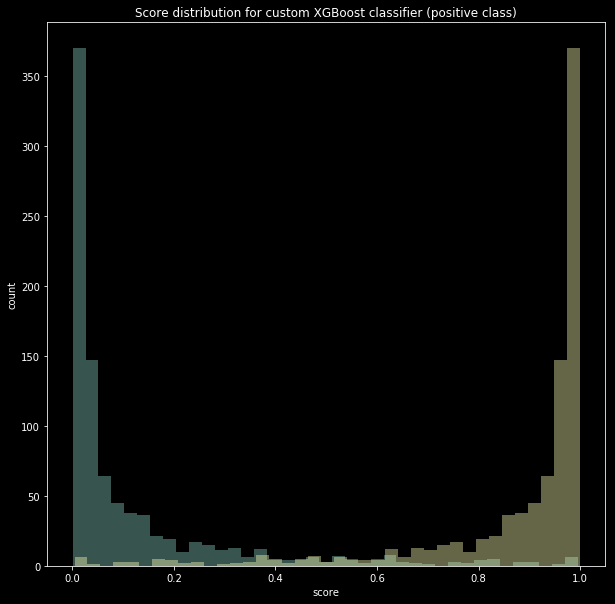

In [91]:
make_score_distribution(df=df_test, 
                        proba_cols=['xgb_proba_0', 'xgb_proba_1'], 
                        true_col='y_true', 
                        true_label=1, 
                        title='Score distribution for custom XGBoost classifier (positive class)')

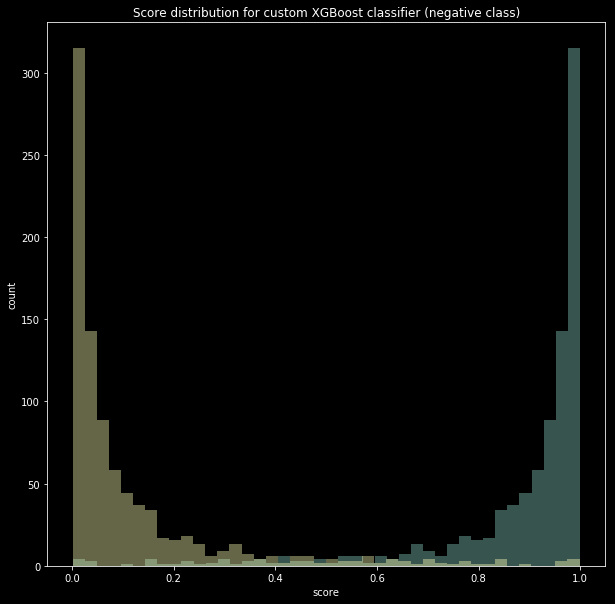

In [92]:
make_score_distribution(df=df_test, 
                        proba_cols=['xgb_proba_0', 'xgb_proba_1'], 
                        true_col='y_true', 
                        true_label=0, 
                        title='Score distribution for custom XGBoost classifier (negative class)')

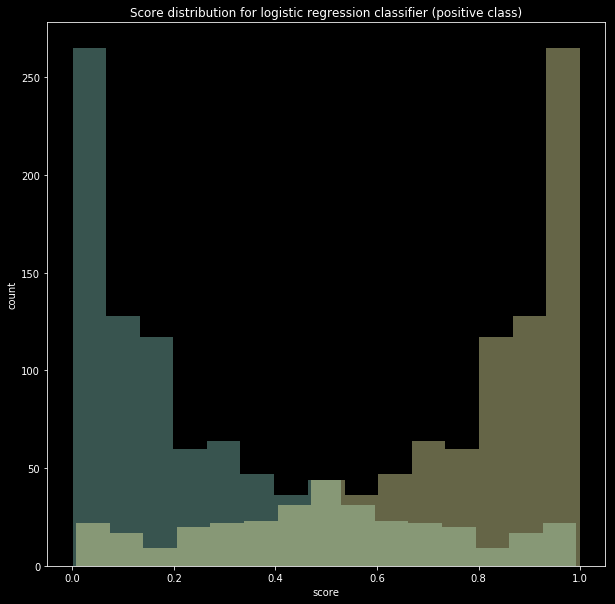

In [88]:
make_score_distribution(df=df_test, 
                        proba_cols=['lg_proba_0', 'lg_proba_1'], 
                        true_col='y_true', 
                        true_label=1, 
                        title='Score distribution for logistic regression classifier (positive class)')

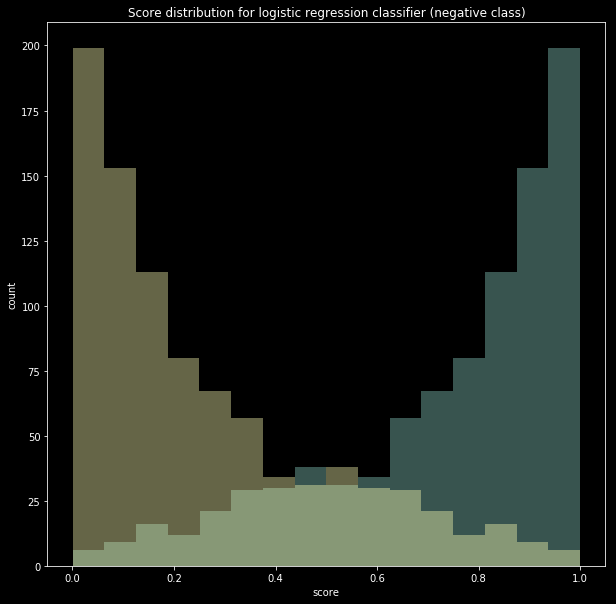

In [89]:
make_score_distribution(df=df_test, 
                        proba_cols=['lg_proba_0', 'lg_proba_1'], 
                        true_col='y_true', 
                        true_label=0, 
                        title='Score distribution for logistic regression classifier (negative class)')